In [26]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import sys
from scipy.stats import multivariate_normal
from copy import deepcopy
sys.path.append('..')
import os

from src.data_utils import grid_data
from src.estimators.adaptive import AdaptiveEstimator
from src.estimators.static import SecurityAssessmentEstimator
from src.samplers.sampler import Sampler
path_to_saves = '../saves_1d'

# Set up function, draw

In [27]:
def b(x, y=None):
    if y is not None:
        return (x < 2) * (x > -2) * x 
    else:
        return (x[0] < 2) * (x[0] > -2) * x

def p(x, y=None): 
    if y is not None:
        return (x < 0.5) * (x > -0.5) * x
    else:
        return (x[0] < 0.5) * (x[0] > -0.5) * x

# Estimators and the estimate

In [28]:
fluct_gen = [0, 1]
fluct_load = []
adaestimator = AdaptiveEstimator(functions=[b, p], fluct_gens_idxs=fluct_gen, fluct_loads_idxs=fluct_load, mu_init=np.ones(len(fluct_gen)) * 0, sigma_init=(np.ones(len(fluct_gen))*0.5, np.ones(len(fluct_load))*0.5), batch_size=16)
staticestimator = SecurityAssessmentEstimator(functions=[b, p], fluct_gens_idxs=fluct_gen, fluct_loads_idxs=fluct_load,)

In [29]:
get_sample = lambda: np.random.multivariate_normal(np.zeros(len(fluct_gen)), np.eye(len(fluct_gen)) * 0.5)
get_sample_load = None#lambda: {"P": np.random.multivariate_normal(np.zeros(len(fluct_load)), np.eye(len(fluct_load)) * 0.5), 
                       #     "Q": np.random.multivariate_normal(np.zeros(len(fluct_load)), np.eye(len(fluct_load)) * 0.5), }
sampler = Sampler(len(fluct_gen), len(fluct_load), get_sample, get_sample_load).sample()
samples = [(next(sampler), ) for i in range(2000)]
estimate_static = staticestimator.estimate(samples, parallel=False)

100%|███████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 46480.46it/s]


In [30]:
mc_estimates = [np.sum(estimate_static[:i]) / i for i in range(1, len(estimate_static))]

In [31]:
adaestimator.test_samples(2000)
is_estimates = [np.sum(adaestimator.weightes_outcomes[:i]) / i for i in range(1, adaestimator.n_steps)]

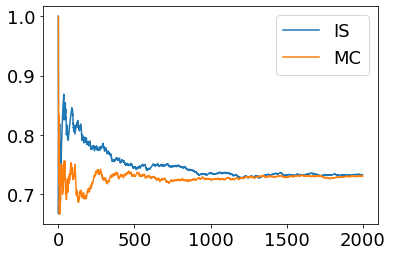

In [32]:
plt.plot(is_estimates[:2000], label='IS')
plt.plot(mc_estimates[:2000], label='MC')
plt.legend()


# STD of IS and MC

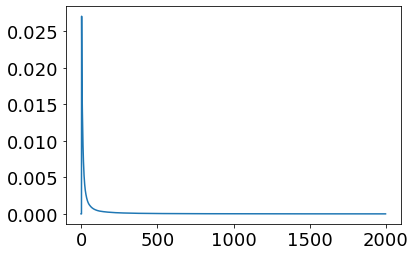

In [33]:
mc_std_estimates = [np.std(mc_estimates[:i]) / i for i in range(1, len(mc_estimates))]
plt.plot(mc_std_estimates)
if not os.path.exists(path_to_saves):
    os.makedirs(path_to_saves)
plt.savefig(path_to_saves + "1d_mc_std.png")

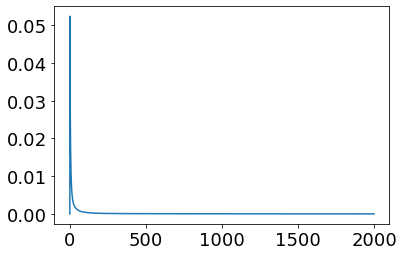

In [34]:
is_std_estimates = [np.std(is_estimates[:i]) / i for i in range(1, len(is_estimates))]
plt.plot(is_std_estimates)
if not os.path.exists(path_to_saves):
    os.makedirs(path_to_saves)
plt.savefig(path_to_saves + "1d_is_std.png")

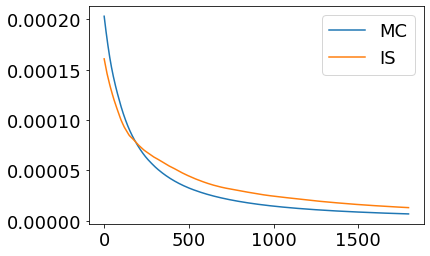

In [35]:
plt.plot(mc_std_estimates[200:], label='MC')
plt.plot(is_std_estimates[200:], label='IS')
plt.legend()

if not os.path.exists(path_to_saves):
    os.makedirs(path_to_saves)
plt.savefig(path_to_saves + "1d_mc_is_std_comparison.png")

# Path of mean

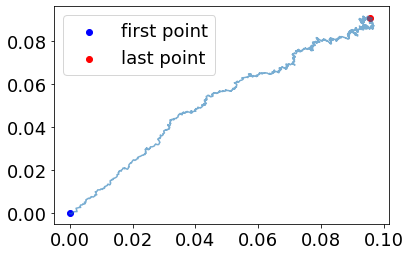

In [36]:
mus_hist = np.array(adaestimator.mu_history)
plt.plot(mus_hist[:, 0], mus_hist[:, 1], alpha=0.6)
plt.scatter([mus_hist[:, 0][0]], [mus_hist[:, 1][0]], color='blue', label='first point')
plt.scatter([mus_hist[:, 0][-1]], [mus_hist[:, 1][-1]], color='red', label='last point')
plt.legend()
